<a href="https://colab.research.google.com/github/aneelabashir786/AI-ML-Tasks/blob/main/aneela_bashir_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install clean-text        # For cleaning and preprocessing text
!pip install Unidecode         # For converting Unicode text to ASCII
!pip install nltk              # Natural Language Toolkit - used for tokenization, stopwords, POS tagging, etc.
!pip install gensim keras      # Gensim: For Word2Vec embeddings; Keras: For building and training deep learning models (RNN, LSTM, etc.)


In [2]:
import nltk                                 # Natural Language Toolkit for text processing
nltk.download('stopwords')
nltk.download('punkt')                        # Pre-trained tokenizer for word/sentence tokenization
nltk.download('punkt_tab')                   # Internal helper file for 'punkt' (usually auto-installed with 'punkt')
nltk.download('averaged_perceptron_tagger')  # POS tagger needed for part-of-speech tagging
nltk.download('wordnet')                     # WordNet lexical database (used for lemmatization and synonym replacement)
nltk.download('omw-1.4')                     # Open Multilingual WordNet – supports multilingual WordNet and SynonymAug

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

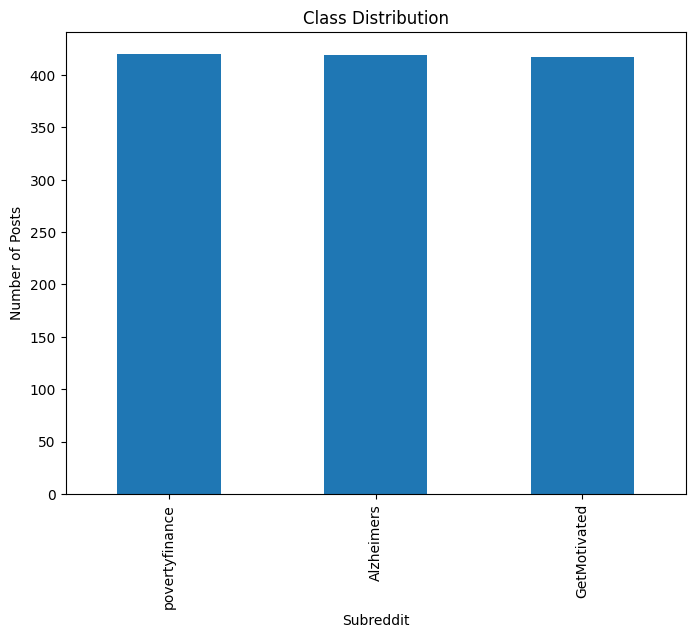

Missing post_text count by subreddit:
 subreddit
GetMotivated      92
povertyfinance    39
Alzheimers        15
Name: count, dtype: int64
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4163 - loss: 1.0840 - val_accuracy: 0.3968 - val_loss: 1.0653
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4294 - loss: 1.0522 - val_accuracy: 0.4206 - val_loss: 1.0233
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4968 - loss: 0.9887 - val_accuracy: 0.5595 - val_loss: 0.8650
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6035 - loss: 0.7933 - val_accuracy: 0.5833 - val_loss: 0.8629
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6393 - loss: 0.7549 - val_accuracy: 0.7024 - val_loss: 0.6203
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6178 - loss: 0.6847 - val_accuracy: 0.6587 - val_loss: 0.7527
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6647 - loss: 0.6860 - val_accuracy: 0.7341 - val_loss: 0.5835
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7143 - loss: 0.5925 - val_accuracy: 0.6706 - val_loss: 0.

LSTM Test Accuracy: 0.7341269850730896
Model and preprocessing files saved!
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        84
           1       0.92      0.39      0.55        84
           2       0.62      0.90      0.73        84

    accuracy                           0.73       252
   macro avg       0.78      0.73      0.71       252
weighted avg       0.78      0.73      0.71       252



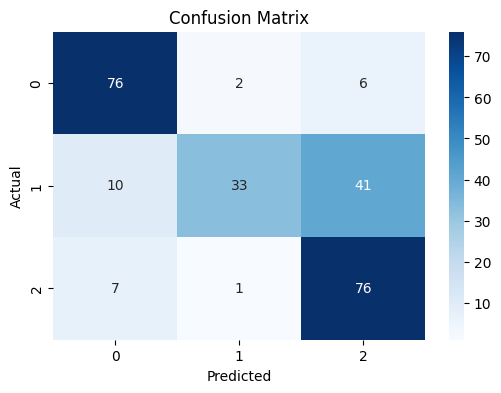

In [4]:

# 1. Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import joblib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from cleantext import clean

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

# 2. Load and Filter Data

df = pd.read_csv("reddit_posts_and_comments.csv")[['post_text', 'subreddit']]
selected_categories = ['Alzheimers', 'povertyfinance', 'GetMotivated']
df = df[df['subreddit'].isin(selected_categories)]


# 3. Class Distribution Visualization

plt.figure(figsize=(8, 6))
df['subreddit'].value_counts().plot(kind='bar')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.title('Class Distribution')
plt.show()


# 4. Handle Missing Values

print("Missing post_text count by subreddit:\n",
      df[df['post_text'].isnull()]['subreddit'].value_counts())
df['post_text'] = df['post_text'].fillna('unknown')


# 5. Save Stopwords for Future Use

stop_words = set(stopwords.words('english'))
joblib.dump(stop_words, "stopwords.pkl")


# 6. Define Preprocessing Function

def preprocess_text_train(text, stop_words):
    # Clean text
    cleaned = clean(
        str(text),
        lower=True,
        no_urls=True, no_emails=True, no_phone_numbers=True,
        no_digits=True, no_numbers=True, no_currency_symbols=True, no_punct=True,
        lang="en"
    )
    # Remove short words
    cleaned = ' '.join([w for w in cleaned.split() if len(w) > 2])
    # Remove stopwords
    cleaned = ' '.join([w for w in cleaned.split() if w not in stop_words])
    # Tokenize
    tokens = word_tokenize(cleaned)
    return tokens

# Apply preprocessing
df['post_text'] = df['post_text'].apply(lambda x: preprocess_text_train(x, stop_words))


# 7. Label Encoding

le = LabelEncoder()
df['subreddit'] = le.fit_transform(df['subreddit'])


# 8. Train Word2Vec Embeddings

tokenized_posts = df['post_text']
w2v_model = Word2Vec(sentences=tokenized_posts, vector_size=100,
                     window=5, min_count=1, workers=4)

word_index = {word: i + 1 for i, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_index) + 1
embedding_dim = w2v_model.vector_size

# Embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

# Convert text to sequences
post_sequences = tokenized_posts.apply(lambda tokens: [word_index.get(word, 0) for word in tokens])
max_len = 100
padded_sequences = pad_sequences(post_sequences, maxlen=max_len, padding='post', truncating='post')


# 9. Train-Test Split

X = padded_sequences
y = to_categorical(df['subreddit'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)


# 10. Build and Train LSTM Model

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    LSTM(64),
    Dense(y.shape[1], activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=32, callbacks=[early_stop])

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print("LSTM Test Accuracy:", accuracy)


# 11. Save Model and Assets

model.save("lstm_model.h5")
joblib.dump(word_index, "word_index.pkl")
joblib.dump(le, "label_encoder.pkl")

# Save preprocessing function
with open("preprocessing.pkl", "wb") as f:
    dill.dump(preprocess_text_train, f)

print("Model and preprocessing files saved!")


# 12. Classification Report and Confusion Matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
